In [99]:
# 1.目的
# 最終コーナーの通過順位を予想したものが着番の説明変数として有用なのか確認する（2025/9/22現在、有用ではない）

In [3]:
# インポート
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# CSVファイルの読み込み
df = pd.read_csv('input_編集後_説明変数追加.csv', encoding='cp932')
print(f"dfの行数は {len(df)} ")
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
# フィルタ条件を適用
filtered_df = df[
    (df['race_date'].dt.year >= 2023) &
    (df['race_date'].dt.year <= 2024)
]
print(f"filtered_dfの行数は {len(filtered_df)} ")
# レースID、馬番順に並び替え
filtered_df = filtered_df.sort_values(by=['race_id', 'horse_number'])
# レースごとの馬のタイム指数の平均値を計算し、タイム指数との差を計算する
race_avg_time_index = filtered_df.groupby('race_id')['time_index_average_1'].transform('mean')
# 平均との差を新しいカラムとして追加
filtered_df['time_index_diff_from_avg'] = filtered_df['time_index_average_1'] - race_avg_time_index
# NaN を除外（最低限のデータ整備）
# df = filtered_df.dropna(subset=['race_id', 'position_4', 'style_encoded', 'rank_diff'])
df = filtered_df
# 分母：全体の出現数（position_4, style_encodedの組み合わせ）
total_counts = (
    df
    .groupby(['position_4', 'style_encoded'])
    .size()
    .reset_index(name='total')
)
# 分子：flag_max_rank_diff_actual == 1 の馬だけ抽出
df_max = df[df['flag_max_rank_diff_actual'] == 1]
# その組み合わせの出現数をカウント
match_counts = (
    df_max
    .groupby(['position_4', 'style_encoded'])
    .size()
    .reset_index(name='matched')
)
# マージして確率を計算
result = pd.merge(total_counts, match_counts, on=['position_4', 'style_encoded'], how='left')
result['matched'] = result['matched'].fillna(0)
result['probability'] = result['matched'] / result['total']
# 結果を表示
print(result.sort_values(by=['style_encoded', 'position_4']).head(32))
print(f"Matched 合計: {result['matched'].sum()}")
print(f"Total 合計: {result['total'].sum()}")
# prob_mapは既に作成済み（position_4, style_encoded をキーにした辞書）
prob_map = result.set_index(['position_4', 'style_encoded'])['probability'].to_dict()
# 学習データと検証データの判定条件（例としてrace_dateで分割）
# ここは適宜調整してください
train_mask = filtered_df['race_date'].dt.year == 2023  # 例: 2023年が学習データ
test_mask = filtered_df['race_date'].dt.year == 2024   # 例: 2024年が検証データ
# 新カラム初期化
filtered_df['probability_of_max_rank_diff'] = np.nan
# 学習データには (position_4, style_encoded) をキーにprobability割り当て
filtered_df.loc[train_mask, 'probability_of_max_rank_diff'] = filtered_df.loc[train_mask].apply(
    lambda row: prob_map.get((row['y4_rank'], row['style_encoded']), np.nan),
    axis=1
)
# 検証データには (y4_rank, style_encoded) をキーにprobability割り当て
filtered_df.loc[test_mask, 'probability_of_max_rank_diff'] = filtered_df.loc[test_mask].apply(
    lambda row: prob_map.get((row['y4_rank'], row['style_encoded']), np.nan),
    axis=1
)
# 確認
print(filtered_df.loc[train_mask, [
    'race_id', 'horse_number', 'position_4', 'y4_rank', 'style_encoded', 'probability_of_max_rank_diff'
]].head(8))
print(filtered_df.loc[test_mask, [
    'race_id', 'horse_number', 'position_4', 'y4_rank', 'style_encoded', 'probability_of_max_rank_diff'
]].head(8))

# filtered_dfをCSVファイルとして出力
filtered_df.to_csv('C:\\Users\\ryo\\Downloads\\filtered_df.csv', index=False, encoding='cp932')

dfの行数は 2280 
filtered_dfの行数は 1528 
    position_4  style_encoded  total  matched  probability
0          1.0            1.0     54      0.0     0.000000
4          2.0            1.0     34      0.0     0.000000
8          3.0            1.0     33      1.0     0.030303
12         4.0            1.0     11      3.0     0.272727
16         5.0            1.0     21      1.0     0.047619
20         6.0            1.0      5      1.0     0.200000
24         7.0            1.0      5      0.0     0.000000
28         8.0            1.0     11      2.0     0.181818
1          1.0            2.0    103      0.0     0.000000
5          2.0            2.0     77      2.0     0.025974
9          3.0            2.0     55      3.0     0.054545
13         4.0            2.0     50      4.0     0.080000
17         5.0            2.0     36      3.0     0.083333
21         6.0            2.0     26      3.0     0.115385
25         7.0            2.0     23      1.0     0.043478
29         8.0       

In [21]:
# 説明変数
features = [
    'probability_of_max_rank_diff',
    'time_index_diff_from_avg',
    'jockey_place_rate_9',
    'conditional_place_rate_10'
]
# === ① 除外処理 ===
# 説明変数 + race_id を含む DataFrame を用意
x_with_race = filtered_df[features + ['race_id']].copy()
# race_id ごとに、各特徴量の NaN 数をカウント
nan_counts_per_race = x_with_race.groupby('race_id')[features].apply(lambda g: g.isna().sum())
# 各レースについて、いずれかの説明変数に NaN が「5件以上」あるかどうかを判定
race_ids_to_exclude = nan_counts_per_race[(nan_counts_per_race >= 5).any(axis=1)].index
# 除外
filtered_df = filtered_df[~filtered_df['race_id'].isin(race_ids_to_exclude)].reset_index(drop=True)
# === ② NaN補完処理 ===
# filtered_df から必要なカラムを含む x をコピー（補完対象）
x = filtered_df[features + ['race_id']].copy()
def fill_na_with_group_mean(group, feature):
    na_count = group[feature].isna().sum()
    if na_count <= 4:
        mean_val = group[feature].mean()
        group[feature] = group[feature].fillna(mean_val)
    return group
for feature in features:
    x = x.groupby('race_id', group_keys=False).apply(lambda g: fill_na_with_group_mean(g, feature))
# 最終的な x（説明変数）から race_id を除外
x = x.drop(columns=['race_id'])
filtered_df[features] = x
# 目的変数
y = filtered_df["finish_rank"]
# それぞれの説明変数についてNaNをカウント
nan_counts = filtered_df[features].isna().sum()
print(nan_counts)
# レースIDの先頭2桁を抽出（文字列として扱う）
filtered_df.loc[:, 'race_id_year'] = filtered_df['race_id'].astype(str).str[:2]
# 件数カウント
count_23 = (filtered_df['race_id_year'] == '23').sum()
count_24 = (filtered_df['race_id_year'] == '24').sum()
# 割合を計算
rate_23 = round(count_23 / (count_23 + count_24) ,10) + 0.001
# 結果表示
print(f"24の割合: {rate_23:.10f}")
# 学習データと検証データの分割（検証データ割合はrate_24）
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=rate_23, shuffle=False)
# モデルの学習
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model.fit(x_train, y_train)
# 予測
y_pred = model.predict(x_test)
# y*_predの評価
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
# y*_rankの評価
# 予測結果を DataFrame に変換して race_id と紐付け
y_pred_df = pd.DataFrame({
    'race_id': filtered_df.loc[x_test.index, 'race_id'].values,
    'y_pred': y_pred
})
# 各レースごとに予測値の小さい順に順位を振る（昇順）
y_pred_df['y_rank'] = y_pred_df.groupby('race_id')['y_pred'].rank(method='first').astype(int)
# 3. 実着順を追加
y_pred_df['y_actual'] = y_test.values
# 正解率（的中率）の計算と出力
correct_top1_count = ((y_pred_df['y_rank'] == 1) & (y_pred_df['y_actual'] == 1)).sum()
unique_race_count = y_pred_df['race_id'].nunique()
top1_accuracy = correct_top1_count / unique_race_count
print(f"1着予測的中率: {top1_accuracy:.4f} （{correct_top1_count} / {unique_race_count}）")
# 実データを出力して確認
y_pred_df.sort_values(by=['race_id', 'y_actual'], ascending=[True, True]).head(56)

C:\Users\ryo\AppData\Local\Temp\ipykernel_3520\222110613.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  x = x.groupby('race_id', group_keys=False).apply(lambda g: fill_na_with_group_mean(g, feature))
C:\Users\ryo\AppData\Local\Temp\ipykernel_3520\222110613.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  x = x.groupby('race_id', group_keys=False).apply(lambda g: fill_na_with_group_mean(g, feature)

probability_of_max_rank_diff    0
time_index_diff_from_avg        0
jockey_place_rate_9             0
conditional_place_rate_10       0
dtype: int64
24の割合: 0.5222765957
RMSE: 1.9763
R2 Score: 0.2562
1着予測的中率: 0.3778 （34 / 90）


,race_id,y_pred,y_rank,y_actual
5,240101C05,2.638234,1,1
3,240101C05,5.011388,4,2
2,240101C05,4.122201,2,3
1,240101C05,4.242588,3,4
0,240101C05,5.997761,6,6
6,240101C05,7.354464,7,7
4,240101C05,5.040533,5,8
7,240101C11,4.351870,6,1
14,240101C11,4.170645,5,2
10,240101C11,2.846705,1,3


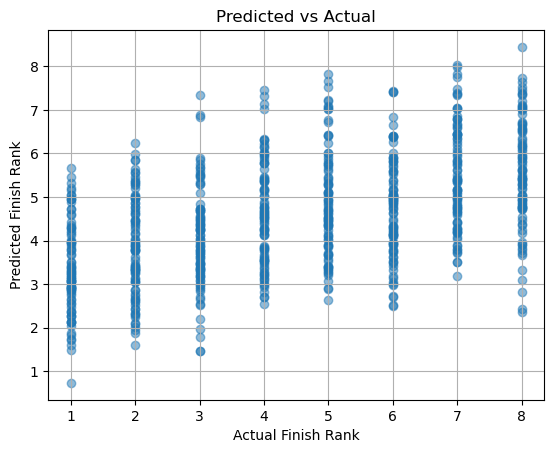

各特徴量の重要度（大きいほど重要）:
                        Feature  Importance
1      time_index_diff_from_avg    0.433041
3     conditional_place_rate_10    0.195549
2           jockey_place_rate_9    0.187002
0  probability_of_max_rank_diff    0.184408


C:\Users\ryo\AppData\Local\Temp\ipykernel_11848\1579747339.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')


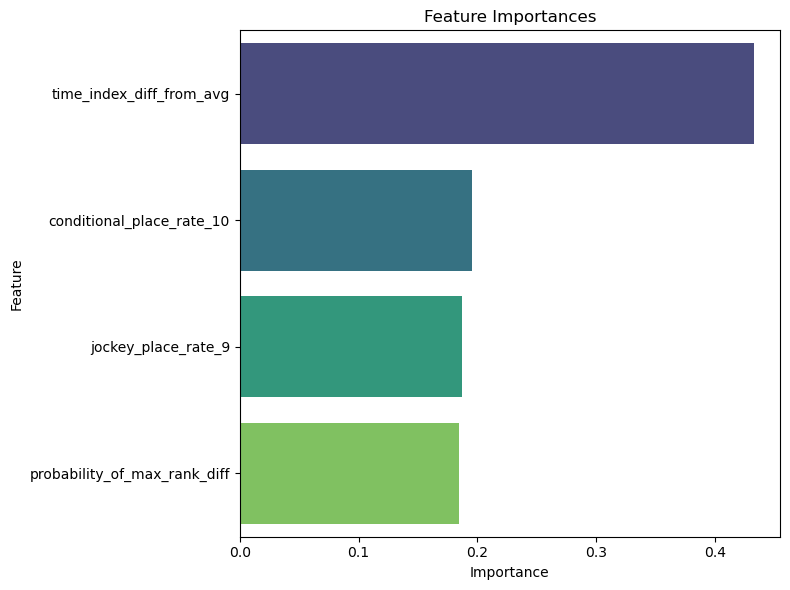

In [64]:
# 予想と正解のプロット
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual Finish Rank")
plt.ylabel("Predicted Finish Rank")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()
# 特徴量の重要度
importances = model.feature_importances_
feature_names = x.columns
# DataFrameにしてソート
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("各特徴量の重要度（大きいほど重要）:")
print(importance_df)
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# メモ
# 説明変数にprobability_of_max_rank_diffを含めるとR2が下がるため、
# probability_of_max_rank_diffの重要度が2番目に高くなっているのはおかしい

In [15]:
# filtered_dfをCSVファイルとして出力
filtered_df.to_csv('C:\\Users\\ryo\\Downloads\\filtered_df.csv', index=False, encoding='cp932')